# Technical notebook - Exploratory Data Analysis

### About Lending Club

Lending Club is the world leader in p2p lending having issued over ($9 billion) dollars in loans since they began in 2007. They are growing at a rate in excess of (150% a year).

source: https://www.lendacademy.com/lending-club-review/

### How it Works

Peer to peer lending at Lending Club is a very simple process. It begins with the borrower. They apply for a loan and if they meet certain criteria (such as a minimum 660 FICO score) their loan is added to Lending Club’s online platform. Investors can browse the loans on the platform and build a portfolio of loans. The minimum investment an investor can make is just $25 per loan. Each portion of a loan is called a note and smart investors build a portfolio of notes to spread their risk among many borrowers.

Lending Club will perform some level of verification on every borrower. As this verification process is happening investors can be funding portions of the loans. If the borrower passes verification the loan is approved for investors and will be issued to the borrower if fully funded. If the borrower fails verification the loan will not be issued. It will be deleted from the platform and all money that had been invested will be returned to the respective investors.

A loan can stay on the platform for up to 14 days. Most loans are funded much quicker than that and once funded the loan will be deleted from the platform. Approved borrowers will receive their money (less an origination fee) in just a couple of business days once funding is complete and then begin making payments within 30 days. These payments will be for principal plus interest on a standard amortization schedule.

### Explanation of loan grades

Lending Club categorizes borrowers into seven different loan grades: A through G. Within each loan grade there are five sub-grades meaning there are 35 total loan grades for borrowers from A1 down to G5. Where a borrower is graded depends on many factors the most important of which is the data held in the borrower’s credit report. The better credit history a borrower has the better their loan grade with the very best borrowers receiving an A1 grade, which carries the lowest interest rate.

Lending Club will pull the latest credit report for every borrower and take the data held in that report and other factors such as loan amount and loan term to determine the interest rate. Lending Club provides more information on their Interest Rates and How We Set Them page on their site. Learn more about the Lending Club borrower experience in this video where I apply for a Lending Club loan.

### What are the Risks?

Every investor should consider the risks of an investment before committing their money.  Investing with p2p lending has a number of risks:

**Borrower defaults** – the loans are unsecured so an investor has little recourse if the borrower decides not to pay. The annual default rate across all grades at Lending Club is around 6 or 7% with higher risk borrowers having a higher default rate.

**Lending Club bankruptcy** – This is a much smaller risk today than it was several years ago because Lending Club is making money and has had an influx of cash with the recent IPO. But the risk will always be there. In the unlikely event of a bankruptcy, there is a backup loan servicer who will take over servicing the loans but there would likely be some disruption and investors could lose some principal.

**Interest rate risk** – the loan terms are three or five years so during this time interest rates could increase substantially. If an FDIC insured investment is paying 6% it makes investing in a Lending Club loan at 7% not the best investment.

**Poor loan diversification** – many new investors get caught in this trap. They do not take advantage of the \\$25 minimum investment. If you invest in 20 loans at \\$250 you are running a much higher risk than if you invest in 200 loans at \\$25. If you only have 20 loans one default could wipe out most of your gains.

**Liquidity risk** – There is a secondary market on Lending Club where loans can be sold but if you need to liquidate your entire investment you will likely lose some principal in the process.

**Market-wide event or recession** – While p2p lending has been around since the latest recession in 2008, the asset class still remains untested when platforms were originating significant volumes. In a recession, defaults will increase and thus will result in a decrease in investor returns.


### !! **This analysis focuses on borrower defaults and tries to provide a better classification** !!

### Data source:

https://www.lendingclub.com/info/download-data.action


Data includes yearly consumer loans given out with information was available at the time of the application and payment information. 

They also provide a short description of the columns.

This analysis is based on **LendingClub loan data from 2014.**


### Steps of the feature selection and feature engineering:
1. Understanding the columns
2. First round feature selection
3. Handling missing values - drop rows
4. Determine the target feature
5. Exploring object type features - data conversion and EAD
6. Exploring numeric features - collinearity and EAD
7. Preparing dataset for modeling

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

### Importing Dataset

In [2]:
# !ls -lath LendingClub

In [3]:
#reading excel file which contains the column descriptions
description = pd.read_excel('LendingClub/LCDataDictionary.xlsx')

Reading from csv file:

In [4]:
# reading Lending Club loan data from 2014
# data_lc = pd.read_csv('LendingClub/LoanStats3c_securev1.csv', low_memory=False, header=1)
# data_lc.shape

Reading from zip file:

In [5]:
#read in Lending Club loan data from zip file
from zipfile import ZipFile
zip_file = ZipFile('LendingClub/LoanStats3c_securev1.csv.zip')
data_lc = pd.read_csv(zip_file.open('LoanStats3c_securev1.csv'), low_memory=False, header=1)
data_lc.shape

(235631, 150)

In [6]:
data_lc.loan_amnt.isna().sum() #there are rows without loan amount

2

In [7]:
#removed two rows with full NAN values
data_lc = data_lc.loc[data_lc.loan_amnt.notnull()]
data_lc.shape

(235629, 150)

# I. Feature selection and feature engineering

## 1. Understanding the columns

In order to understand the columns we created a dataframe with column names, two examples, datatype, number of missing values, and the long description. The dataframe was exported to excel to make decision on columns. The result is stored in col_selection.xlsx.

In [8]:
from preprocessing.loan_helper import column_description
desc = column_description(data_lc, description) #column_description() is my own function to create this table

In [9]:
pd.set_option('display.max_colwidth', -1) #this allows us to see the very long description, if exceeds 50 char
desc.head(4)

,col_name,exmp1,exmp2,dtype,Description,nan_counts
0,id,37662224,36804663,object,A unique LC assigned ID for the loan listing.,0
1,member_id,NaN,NaN,float64,A unique LC assigned Id for the borrower member.,235629
2,loan_amnt,7650,23325,float64,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.",0
3,funded_amnt,7650,23325,float64,The total amount committed to that loan at that point in time.,0


In [10]:
# desc.to_excel('preprocessing/col_desc_2014.xlsx') #This code is needed only the first time to run our notebook

## 2. First round feauture selection

Originally the dataset contained **150 columns/features**. Features were reduced due to many reasons listet below:

- Discarded columns which were holding **irrelevant** information:
    - id, member_id, url, policy_code, application_type, annual_inc_joint, verification_status_joint, acc_now_delinque
- Discarded columns which contained **redundant** information:
    - funded_amnt, funded_amnt_inv (the difference is funded by LC itself), int_rate, sub_grade, title, fico_range_high, desc (given as purpose)
- Discarded columns that contained **payment or collection** information (34 columns)
- Discarded columns that contained information that were not available at the time of credit application, **future info**
    - issue_d, pymnt_plan, initial_list_status, last_credit_pull_d, last_fico_range_high, last_fico_range_low
- Discarded features that require **too much data processing**
    - emp_title (due to the free format), zip_code (there is a state instead)
- Discarded columns with **too many missing values**

In [11]:
col_selection = pd.read_excel('preprocessing/col_selection_2014.xlsx', index_col=0)
col_selection.head()

,col_name,exmp1,exmp2,dtype,Description,nan_counts,Decision,Cause
0,id,37662224,36804663,object,A unique LC assigned ID for the loan listing.,0,remove,irrelevant
1,member_id,NaN,NaN,float64,A unique LC assigned Id for the borrower member.,235629,remove,irrelevant
2,loan_amnt,7650,23325,float64,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.",0,keep,NaN
3,funded_amnt,7650,23325,float64,The total amount committed to that loan at that point in time.,0,remove,redundant
4,funded_amnt_inv,7650,23325,float64,The total amount committed by investors for that loan at that point in time.,0,remove,redundant


In [12]:
print('The summary of reasons to drop columns:')
print(col_selection.Cause.value_counts(), '\n')
selected_col = col_selection.loc[col_selection.Decision == 'keep', 'col_name'].to_list()
print('The number of selected columns:', len(selected_col))

The summary of reasons to drop columns:
missing         32
collection      22
payment_info    12
irrelevant      9 
redundant       7 
future_info     6 
poor_format     2 
Name: Cause, dtype: int64 

The number of selected columns: 60


In [13]:
# ======== application types =============
print(f'Different types of applications: {data_lc.application_type.unique().tolist()}\n')

# ======== fico scores =========
print('The difference between high and low fico scores, and its distributions:')
print((data_lc.fico_range_high - data_lc.fico_range_low).value_counts(), '\n')

# ======== employment titles =============
print(f'The number of different employment title: {len(data_lc.emp_title.unique()):,}\n')

# ======== ZIP codes =============
print(f'The number of different ZIP codes: {len(data_lc.zip_code.unique())}\n') 

# ======== Columns with Full Missing Values =========
print(f'The number of columns with full of missing values: {sum(data_lc.isna().sum() == len(data_lc))}\n')
# print(f'Columns: {data_lc.columns[data_lc.isna().sum() == len(data_lc)].tolist()}')

# ======== Columns with too many missing values ========
toomany_missing_cols = data_lc.columns[(data_lc.isna().sum() > len(data_lc)/10) &
                                       (data_lc.isna().sum() < len(data_lc))].tolist()
print(f'The number of columns where the missing values exceed 10% of the dataset: {len(toomany_missing_cols)}\n')
# print(f'The columns where the missing values exceeds the 10% of the dataset:\n\n{toomany_missing_cols}\n')
# print(f'There is an overlapping with collection and other reasons to remove these columns.')

Different types of applications: ['Individual']

The difference between high and low fico scores, and its distributions:
4.0    235615
5.0    14    
dtype: int64 

The number of different employment title: 75,353

The number of different ZIP codes: 866

The number of columns with full of missing values: 31

The number of columns where the missing values exceed 10% of the dataset: 27



In [14]:
dataset = data_lc.loc[:, selected_col]
print(f'After removing features, the dataset contains {dataset.shape[0]:,} rows and {dataset.shape[1]} columns.')

After removing features, the dataset contains 235,629 rows and 60 columns.


## 3. Handling missing values - drop rows

In [15]:
print('Columns with missing values sorted by the number of missing values: \n')
missing_cols = dataset.columns[dataset.isna().any()]
for num, col in sorted([(dataset[i].isna().sum(), i) for i in missing_cols]):
    print(num, '\t', col)

Columns with missing values sorted by the number of missing values: 

6 	 avg_cur_bal
125 	 revol_util
2246 	 mths_since_recent_bc
2445 	 bc_open_to_buy
2557 	 percent_bc_gt_75
2611 	 bc_util
7171 	 mo_sin_old_il_acct
7860 	 num_tl_120dpd_2m
12019 	 emp_length
21692 	 mths_since_recent_inq


In [16]:
dataset_with_nan = dataset[dataset.avg_cur_bal.isna() | dataset.revol_util.isna() |
                           dataset.mths_since_recent_bc.isna() | dataset.bc_open_to_buy.isna() |
                           dataset.percent_bc_gt_75.isna() | dataset.bc_util.isna()]

print(f'There are some overlaps in the first 6 cases, alltogether {len(dataset_with_nan)} rows are affected.')
print('These observations contain probably more than one missing values due to overlaps.')

There are some overlaps in the first 6 cases, alltogether 2723 rows are affected.
These observations contain probably more than one missing values due to overlaps.


In [17]:
dataset = dataset.drop(dataset_with_nan.index, axis=0)
print(f'After removing rows, the dataset contains {dataset.shape[0]:,} rows and {dataset.shape[1]} columns.')

After removing rows, the dataset contains 232,906 rows and 60 columns.


In [18]:
print('We decide later on the missing value strategy regarding the remaining features:')
print(dataset.columns[dataset.isna().any()].tolist())

We decide later on the missing value strategy regarding the remaining features:
['emp_length', 'mo_sin_old_il_acct', 'mths_since_recent_inq', 'num_tl_120dpd_2m']


## 4. Determine the target feature

#### For creating the tarrget variable we will use the loan_status variable
#### Meaning of the loan_status categories:
- <b>Fully paid:</b> Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.

- <b>Current:</b> Loan is up to date on all outstanding payments. 

- <b>In Grace Period:</b> Loan is past due but within the 15-day grace period. 

- <b>Late (16-30):</b> Loan has not been current for 16 to 30 days. Learn more about the tools LendingClub has to deal with delinquent borrowers.

- <b>Late (31-120):</b> Loan has not been current for 31 to 120 days. Learn more about the tools LendingClub has to deal with delinquent borrowers.

- <b>Default:</b> Loan has not been current for an extended period of time. Learn more about the difference between “default” and “charge off”.

- <b>Charged Off:</b> Loan for which there is no longer a reasonable expectation of further payments. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance. Learn more about the difference between “default” and “charge off”.

Sosurce: https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

In [19]:
pd.DataFrame(dataset.loan_status.value_counts())

,loan_status
Fully Paid,187402
Charged Off,41090
Current,4171
Late (31-120 days),140
In Grace Period,73
Late (16-30 days),30


In [20]:
pd.crosstab(columns=dataset['loan_status'], index=dataset['term'])

loan_status,Charged Off,Current,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
term,,,,,,
36 months,21999,0,138584,0,0,0
60 months,19091,4171,48818,73,30,140


We decided to ignore the 'gray' categories (250 rows), where there might chance of the recovery of the loan. We will consider the loan being **defaulted (1) if it was charged off**, and **non defaulted (0) if it was fully paid or current**. The 'Current' category consists of only the 60 months term loans, removing them would panalize the long term loans by increasing the default rate within this category.

In [21]:
#Determine default categories into a 'target' variable. 
# The gray category gets -1 and will be removed from the dataset.
target = {'Fully Paid':0, 'Charged Off':1, 'Current':0, 'Late (31-120 days)':-1, 'In Grace Period':-1,
         'Late (16-30 days)':-1}
dataset['target'] = dataset.loan_status.apply(lambda x: target[x])

#dropped the rows where the loan status was different
dataset = dataset[dataset.target != -1]

#remove loan_status
dataset = dataset.drop(columns='loan_status', axis=1)

#reset index
dataset = dataset.reset_index(drop=True)

In [22]:
dataset.target.mean()

0.176607367737887

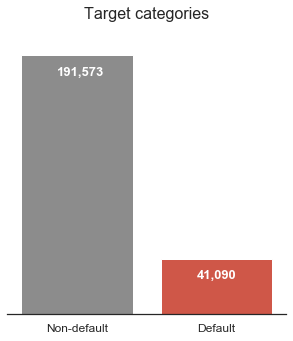

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='white')
fig1 = plt.figure(figsize=(5,5))
ax = sns.countplot(x = 'target', data=dataset, palette=["#8c8c8c", "#e54632"])
for p in ax.patches:
    ax.annotate('{:,}'.format(p.get_height()), (p.get_x()+0.26, p.get_height()-15000), 
                color='white', fontsize=13, fontweight='bold')

plt.title('Target categories\n', fontsize=16)
ax.set_xticklabels(['Non-default', 'Default'], fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel('')
ax.set_ylabel('')
for pos in ['right', 'top', 'left']:
    ax.spines[pos].set_visible(False)
plt.yticks([]);
# fig1.savefig('img/Target_var');


## 5. Exploring object type features - converting data types and EDA

- **term** should be converted into numeric
- **grade** should be converted into numeric due its meaning of an order
- **emp_length** (employment length) column should be converted to numeric, missing values converted to be -1
- **home_ownership** 'any' category (due to the very low num) is converted to be 'rent'
- reduced categories of loan **purpose** by aggregation of close categories
- **addr_state** was converted into **regions**, addr_state column was removed
- **earliest_cr_line** date was converted to numeric (years)
- **revol_util** (revolving utilization) was converted to numeric

The above transformations do not impact dataleakage and can be done before train - test split.

In [24]:
print('Object type columns:')
dataset.select_dtypes('object').columns.tolist()

Object type columns:


['term',
 'grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'revol_util']

#### --> term

In [25]:
print('Distribution of terms:')
dataset.term.value_counts()

Distribution of terms:


 36 months    160583
 60 months    72080 
Name: term, dtype: int64

In [26]:
#converting:
dataset['term'] = dataset.term.apply(lambda x: 36 if x == ' 36 months' else 60)

In [27]:
my_palette = ['#db3b3b', '#c94949', '#b35050', '#9e5757', '#855656', '#735555','#634747', '#5c4949', '#473f3f',\
              '#3b3838','#242424']

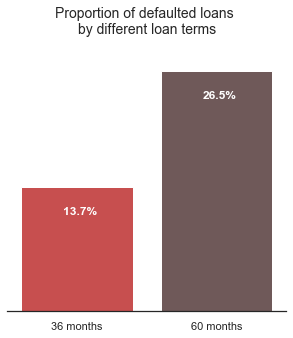

In [28]:
fig2 = plt.figure(figsize=(5,5))
ax = sns.barplot(x=['36 months', '60 months'], y=dataset.groupby('term').target.mean(),
                palette=my_palette[::5])
for p in ax.patches:
        ax.annotate('{:.1%}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()-0.03), 
                    color='white', fontsize=12, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Proportion of defaulted loans \nby different loan terms', fontsize=14)
plt.ylabel('')
plt.yticks([])
plt.ylim([0,0.3]);

#### --> grade

In [29]:
print('Loan distribution by grades')
print(dataset.grade.value_counts().sort_index(), '\n')

print('Default rate by grades')
print(dataset.groupby('grade').target.mean())

Loan distribution by grades
A    35860
B    61292
C    65698
D    42314
E    19741
F    6103 
G    1655 
Name: grade, dtype: int64 

Default rate by grades
grade
A    0.053876
B    0.110912
C    0.185394
D    0.253533
E    0.328504
F    0.367360
G    0.438066
Name: target, dtype: float64


In [30]:
#converting to numeric
grades = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}
dataset['grade'] = dataset.grade.apply(lambda x: grades[x])

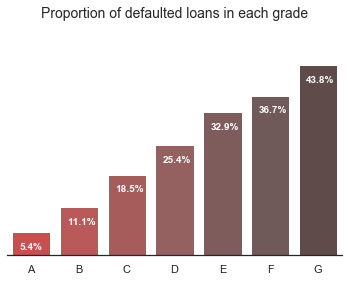

In [31]:
ax = sns.barplot(x=['A', 'B', 'C', 'D', 'E', 'F', 'G'], y=dataset.groupby('grade').target.mean(),
                palette=my_palette)
for p in ax.patches:
        ax.annotate('{:.1%}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()-0.04), 
                    color='white', fontsize=10, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Proportion of defaulted loans in each grade', fontsize=14, pad=20)
plt.ylabel('')
plt.yticks([])
plt.ylim([0,0.5]);

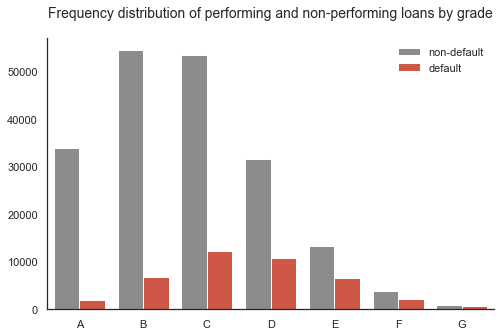

In [32]:
fig2 = plt.figure(figsize=(8,5))
sns.set(style="white")
ax = sns.countplot(x='grade', hue='target', data=dataset, order=[1,2,3,4,5,6,7], palette=["#8c8c8c", "#e54632"])
plt.title('Frequency distribution of performing and non-performing loans by grade', fontsize=14, pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('')
plt.ylabel('')
ax.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G'])
ax.legend(labels=['non-default','default'], loc='upper right', frameon=False);

#### --> emp_length

In [33]:
print(f'Number of missing values: {dataset.emp_length.isna().sum():,}.\n')
print('Distribution of loans by employment length')
print(dataset.emp_length.value_counts())

Number of missing values: 11,797.

Distribution of loans by employment length
10+ years    78366
2 years      20265
3 years      18077
< 1 year     17795
1 year       14433
4 years      13373
7 years      12940
5 years      12906
8 years      11716
6 years      11668
9 years      9327 
Name: emp_length, dtype: int64


In [34]:
#converting to numeric
emp_lens = {'10+ years': 10, '9 years': 9, '4 years': 4, '2 years': 2, '< 1 year': 0,
            '1 year': 1, '6 years': 6, '5 years': 5, '8 years': 8, '7 years': 7, '3 years':3}
dataset['emp_length'] = dataset.emp_length.apply(lambda x: emp_lens.get(x,-1))

In [35]:
print('Missing values were converted to -1.')
print(dataset.emp_length.value_counts())

Missing values were converted to -1.
 10    78366
 2     20265
 3     18077
 0     17795
 1     14433
 4     13373
 7     12940
 5     12906
-1     11797
 8     11716
 6     11668
 9     9327 
Name: emp_length, dtype: int64


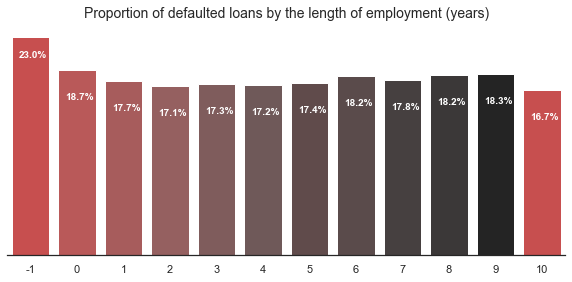

In [36]:
fig = plt.figure(figsize=(10,4))

ax = sns.barplot(x=list(range(-1,11)), y=dataset.groupby('emp_length').target.mean(),
                palette=my_palette)
for p in ax.patches:
        ax.annotate('{:.1%}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()-0.03), 
                    color='white', fontsize=10, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Proportion of defaulted loans by the length of employment (years)', fontsize=14, pad=20)
plt.ylabel('')
plt.yticks([])
plt.ylim([0,0.22]);

#### --> home_ownership

In [37]:
print('Loan distribution by home ownership types')
print(dataset.home_ownership.value_counts())

Loan distribution by home ownership types
MORTGAGE    118337
RENT        91644 
OWN         22681 
ANY         1     
Name: home_ownership, dtype: int64


In [38]:
#converting the 'any' to 'rent'
dataset['home_ownership'] = dataset.home_ownership.apply(lambda x: 'RENT' if x=='ANY' else x)
print(dataset.home_ownership.value_counts())

MORTGAGE    118337
RENT        91645 
OWN         22681 
Name: home_ownership, dtype: int64


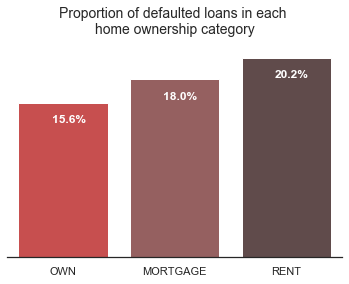

In [39]:
ax = sns.barplot(x=['OWN','MORTGAGE', 'RENT'], y=dataset.groupby('home_ownership').target.mean(),
                palette=my_palette[::3])
for p in ax.patches:
        ax.annotate('{:.1%}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()-0.02), 
                    color='white', fontsize=12, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Proportion of defaulted loans in each \nhome ownership category', fontsize=14)
plt.ylabel('')
plt.yticks([])
plt.ylim([0,0.22]);

#### --> verification_status

In [40]:
print('Loan distribution by the verification of income source')
print(dataset.verification_status.value_counts())

Loan distribution by the verification of income source
Source Verified    98668
Not Verified       67614
Verified           66381
Name: verification_status, dtype: int64


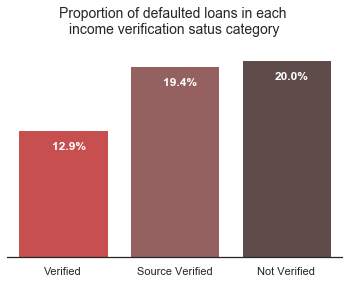

In [41]:
ax = sns.barplot(x=['Verified','Source Verified', 'Not Verified'], 
                 y=dataset.groupby('verification_status').target.mean(),
                 palette=my_palette[::3])
for p in ax.patches:
        ax.annotate('{:.1%}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()-0.02), 
                    color='white', fontsize=12, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Proportion of defaulted loans in each \nincome verification satus category', fontsize=14)
plt.ylabel('')
plt.yticks([])
plt.ylim([0,0.22]);

#### --> purpose

In [42]:
print('Loan distribution by the loan purpose:\n')
print(dataset.purpose.value_counts())

Loan distribution by the loan purpose:

debt_consolidation    141246
credit_card           55155 
home_improvement      12742 
other                 10113 
major_purchase        3783  
medical               2271  
small_business        2237  
car                   1803  
moving                1293  
vacation              1153  
house                 738   
renewable_energy      121   
wedding               8     
Name: purpose, dtype: int64


In [43]:
#aggregation of features
purposes = {'educational': 'other', 'vacation':'major_purchase', 'wedding':'major_purchase', 
            'renewable_energy':'home_improvement'}
dataset['purpose'] = dataset.purpose.apply(lambda x: purposes.get(x,x))

print('After aggregation:\n')
print(dataset.purpose.value_counts())

After aggregation:

debt_consolidation    141246
credit_card           55155 
home_improvement      12863 
other                 10113 
major_purchase        4944  
medical               2271  
small_business        2237  
car                   1803  
moving                1293  
house                 738   
Name: purpose, dtype: int64


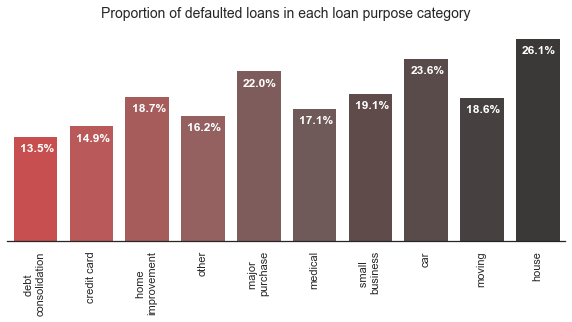

In [44]:
fig = plt.figure(figsize=(10,4))
ax = sns.barplot(x=list(range(1,11)), y=dataset.groupby('purpose').target.mean(), palette=my_palette)

for p in ax.patches:
        ax.annotate('{:.1%}'.format(p.get_height()), (p.get_x()+0.13, p.get_height()-0.02), 
                    color='white', fontsize=12, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Proportion of defaulted loans in each loan purpose category', fontsize=14)
plt.ylabel('')
plt.yticks([])
plt.ylim([0,0.28])
ax.set_xticklabels(['debt \nconsolidation', 'credit card', 'home \nimprovement', 'other', 'major \npurchase',
                    'medical', 'small \nbusiness', 'car', 'moving', 'house'], rotation=90);

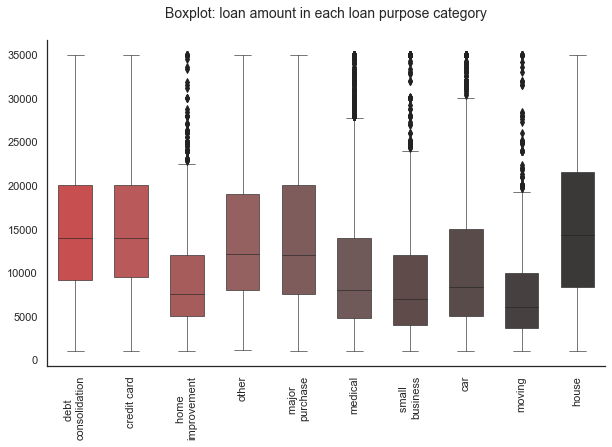

In [45]:
fig = plt.figure(figsize=(10,6))
ax = sns.boxplot(x="purpose", y='loan_amnt', data=dataset, palette=my_palette, width=0.6, linewidth=0.6)

plt.title(label = f'Boxplot for loan amount by purpose', pad=10, fontsize=14)
plt.xlabel('')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)

plt.title('Boxplot: loan amount in each loan purpose category\n', fontsize=14)
plt.ylabel('')
ax.set_xticklabels(['debt \nconsolidation', 'credit card', 'home \nimprovement', 'other', 'major \npurchase',
                    'medical', 'small \nbusiness', 'car', 'moving', 'house'], rotation=90);

#### --> addr_state

In [46]:
#aggregation into five region
regions = {'W':  ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID'], 
               'SW': ['AZ', 'TX', 'NM', 'OK'],
               'SE': ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ],
               'MW': ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND'],
               'NE': ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']}

for region, states in regions.items():
        for state in states:
            dataset.loc[dataset.addr_state == state, 'region'] = region
dataset = dataset.drop(columns = ['addr_state'])

print('Loan distribution by the regions:')
dataset.region.value_counts()

Loan distribution by the regions:


SE    56535
NE    53715
W     53564
MW    41256
SW    27593
Name: region, dtype: int64

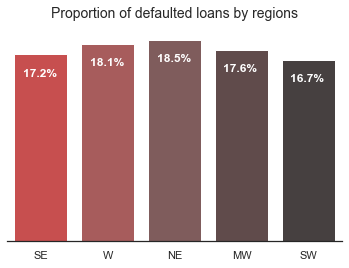

In [47]:
fig = plt.figure(figsize=(6,4))
ax = sns.barplot(x=['SE', 'W', 'NE', 'MW', 'SW'], y=dataset.groupby('region').target.mean(), 
                 palette=my_palette[::2])

for p in ax.patches:
        ax.annotate('{:.1%}'.format(p.get_height()), (p.get_x()+0.13, p.get_height()-0.02), 
                    color='white', fontsize=12, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Proportion of defaulted loans by regions', fontsize=14)
plt.ylabel('')
plt.yticks([])
plt.ylim([0,0.2]);

#### --> earliest_cr_line

In [48]:
print(dataset.earliest_cr_line.value_counts().head())

Aug-2001    1959
Aug-2000    1921
Sep-2000    1705
Aug-2002    1691
Aug-1999    1677
Name: earliest_cr_line, dtype: int64


In [49]:
#conversion from object to numeric ==> years since the earliest_cr_line
dataset['earliest_cr_line'] = dataset.earliest_cr_line.apply(lambda x: 2015 - int(x[-4:]))

print(dataset.earliest_cr_line.value_counts().head())

14    16934
15    16667
13    15165
16    15164
12    13573
Name: earliest_cr_line, dtype: int64


#### --> revol_util

In [50]:
print(dataset.revol_util.head())

0    31.6% 
1    29%   
2    59.4% 
3    100.9%
4    76.2% 
Name: revol_util, dtype: object


In [51]:
#conversion
dataset.loc[:,'revol_util'] = dataset.revol_util.str.strip('%').astype(float)/100

print('After conversion:')
print(dataset.revol_util.head())

After conversion:
0    0.316
1    0.290
2    0.594
3    1.009
4    0.762
Name: revol_util, dtype: float64


In [52]:
print('Object type features:')
print(dataset.select_dtypes('object').columns.tolist())

Object type features:
['home_ownership', 'verification_status', 'purpose', 'region']


## 6. Exploring numeric features

In [53]:
print('The number of qualitative features: ', end='')
print(len(dataset.select_dtypes(['object']).columns))
print('The number of quantitative features (including target): ', end='')

print(len(dataset.select_dtypes(['float64', 'int64']).columns))

The number of qualitative features: 4
The number of quantitative features (including target): 56


### 6.1. Histrogram - EDA

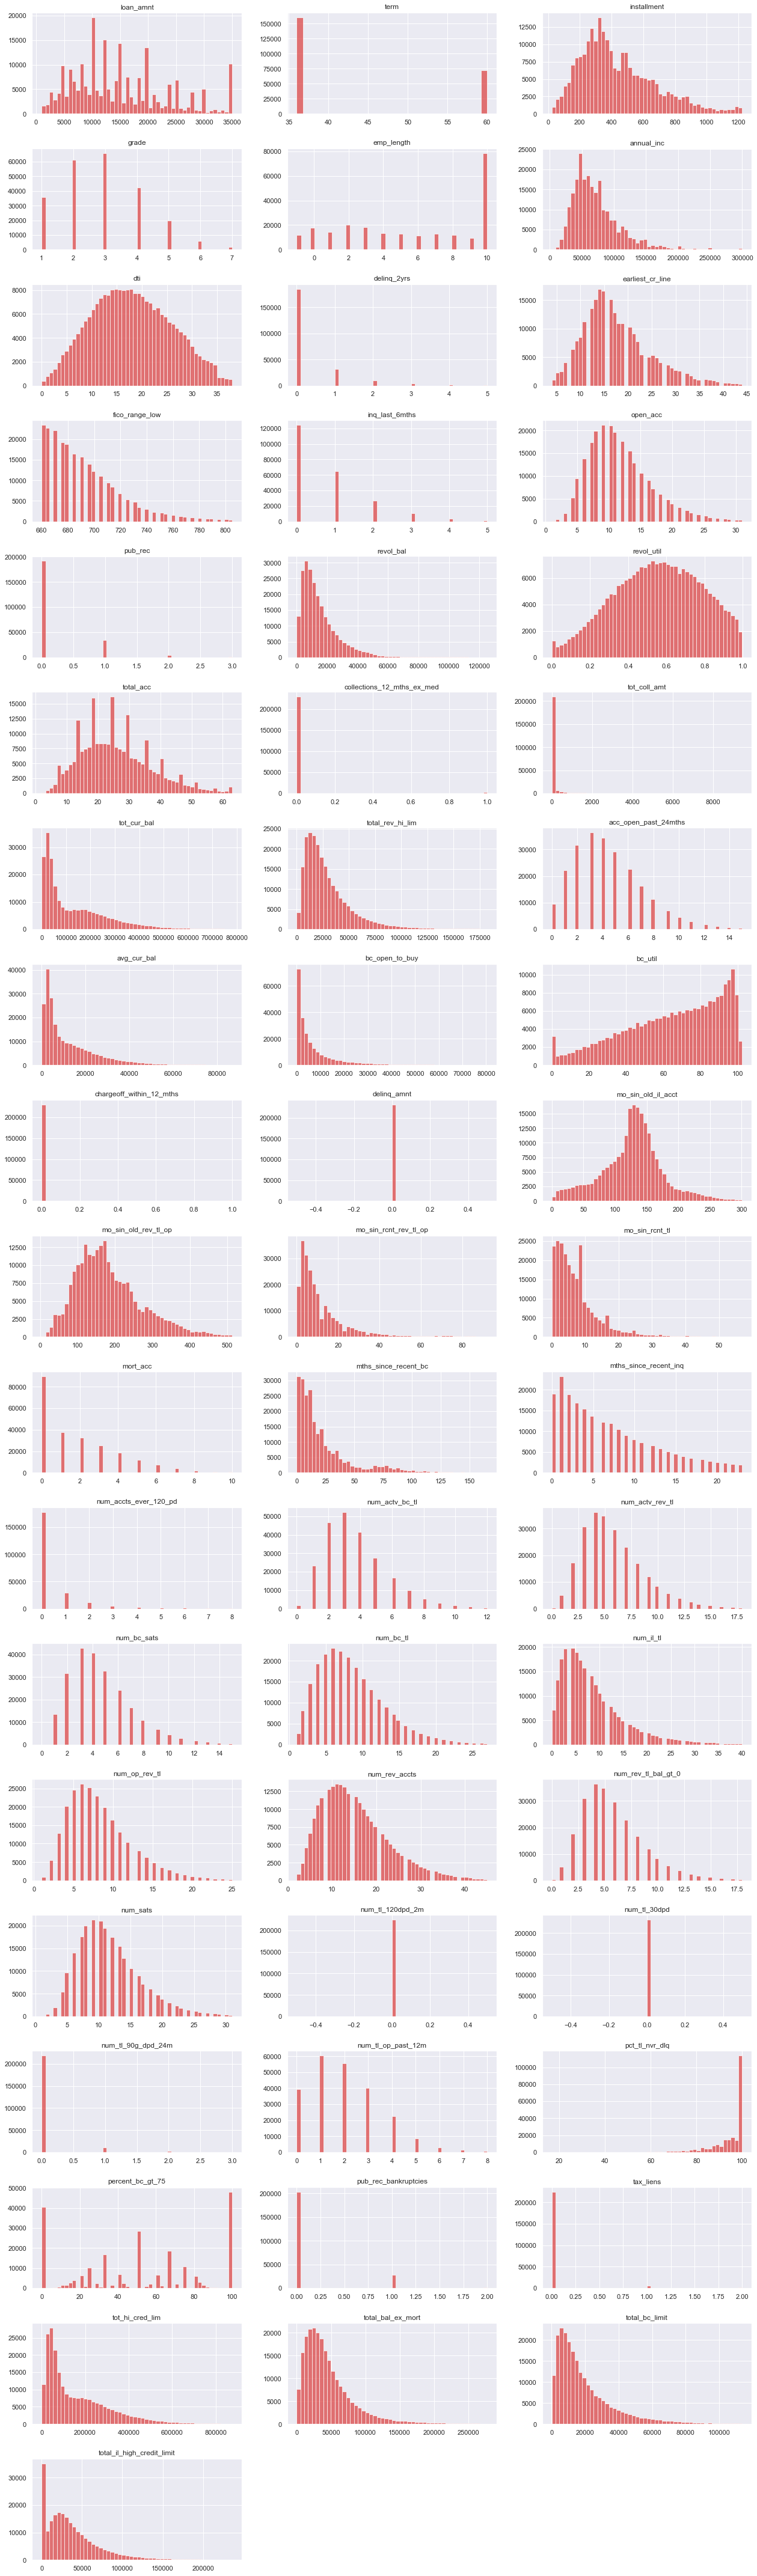

In [54]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(19,3, figsize=(18,60))

num_feats = dataset.select_dtypes(['float64', 'int64']).columns[:-1] #the last feat is the target we dont need
for i, feat in enumerate(num_feats, start=1): 
    ax = plt.subplot(19,3,i)
    feat_top = np.nanpercentile(dataset[feat],99.5)
    sns.distplot(dataset.loc[dataset[feat]<=feat_top, feat], kde=False, axlabel=False,
                 hist_kws={'color':'#db3b3b', 'alpha':0.7})
    ax.set_title(feat)
plt.subplot(19,3,56).set_visible(False)
plt.subplot(19,3,57).set_visible(False)
fig.tight_layout(pad=2.0)
fig.savefig('img/Hist_num_feats.png');

### 6.2. Pairwise correlation
By calculation Pearson correlation coefficient we can detect pairwise correlations between features.

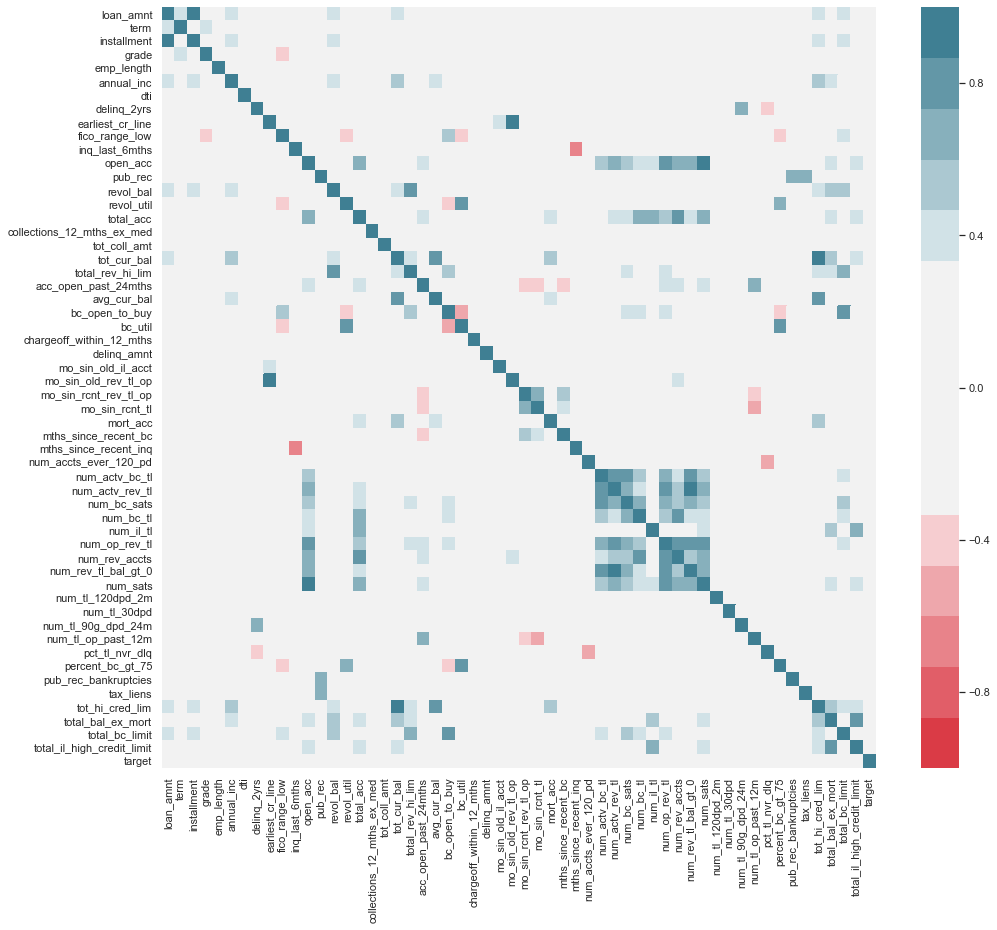

In [55]:
corr = dataset.corr()
plt.figure(figsize=(16,14))
sns.heatmap(corr, vmin=-1, vmax=1, cmap=sns.diverging_palette(10, 220, sep=80, n=15));

#### Scatterplot for the mostly correlated features

In [56]:
# the mostly correlated features
corr_list = []
for i in range(corr.shape[1]):
    for j in range(i+1, corr.shape[1]):
        if corr.iat[i,j]>0.9 or corr.iat[i,j]<-0.9:
            corr_list.append((corr.index[i], corr.columns[j], corr.iat[i,j]))
corr_df = pd.DataFrame(corr_list, columns = ['feat_1','feat_2', 'r_pearson'])                    
corr_df.sort_values(by='r_pearson', ascending=False)

,feat_1,feat_2,r_pearson
2,open_acc,num_sats,0.998639
4,num_actv_rev_tl,num_rev_tl_bal_gt_0,0.989423
3,tot_cur_bal,tot_hi_cred_lim,0.976205
0,loan_amnt,installment,0.947712
1,earliest_cr_line,mo_sin_old_rev_tl_op,0.923426


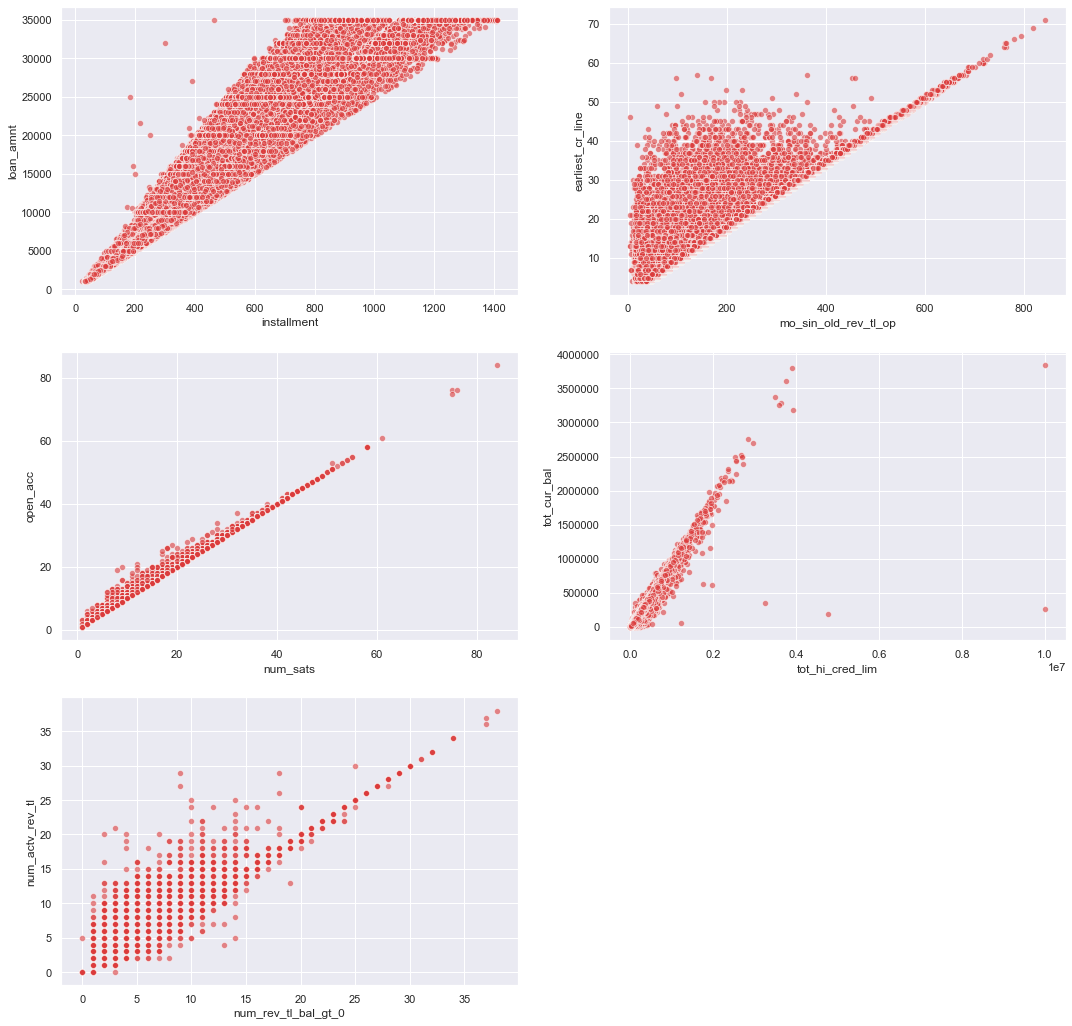

In [57]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18,18))

for i, corr_data in enumerate(corr_list, start=1):
    ax = plt.subplot(3,2,i)
    sns.scatterplot(corr_data[1], corr_data[0], data=dataset, alpha=0.6, color='#db3b3b')
    ax.set_xlabel(corr_data[1])
    ax.set_ylabel(corr_data[0])
plt.subplot(3,2,6).set_visible(False)

### 6.3. Multicollinearity - Variance Inflation Factor

By calculating Variance Inflation Factor we can find multicollinearity between certain featurs. Multicollinearity can be a problem in ordinary least squared analysis. A rule of thumb is that a feature with a VIF over 10 can be removed. As we will see, the multicollinearity is high, but if we not intend to use it for linear regression we can leave those features in our model.

In [58]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#these features object type or target variable:
cols_obj = ['home_ownership', 'verification_status', 'purpose', 'target', 'region']
#these columns contain missing values
cols_mis = dataset.columns[dataset.isna().any()].tolist()

X = dataset.drop(columns = cols_obj + cols_mis, axis=1)
vif = [round(variance_inflation_factor(X.values, i),3) for i in range(X.shape[1])]

In [59]:
sorted(list(zip(X.columns, vif)), key=lambda x: x[1], reverse=True)[:26]

[('open_acc', 2580.755),
 ('num_sats', 2565.279),
 ('total_acc', 1881.8),
 ('num_rev_accts', 732.827),
 ('fico_range_low', 302.308),
 ('num_il_tl', 288.647),
 ('num_rev_tl_bal_gt_0', 274.344),
 ('num_actv_rev_tl', 258.823),
 ('pct_tl_nvr_dlq', 250.405),
 ('loan_amnt', 226.166),
 ('installment', 196.065),
 ('term', 113.257),
 ('tot_cur_bal', 74.199),
 ('tot_hi_cred_lim', 72.967),
 ('num_op_rev_tl', 65.825),
 ('earliest_cr_line', 46.665),
 ('total_bal_ex_mort', 42.474),
 ('bc_util', 41.81),
 ('mo_sin_old_rev_tl_op', 37.099),
 ('num_bc_tl', 32.724),
 ('num_actv_bc_tl', 32.292),
 ('total_il_high_credit_limit', 31.104),
 ('num_bc_sats', 30.788),
 ('revol_util', 27.903),
 ('mort_acc', 20.788),
 ('total_bc_limit', 18.264)]

In [60]:
remove_due_coll = ['open_acc', 'total_acc', 'num_rev_tl_bal_gt_0', 'loan_amnt']

X = dataset.drop(columns=cols_obj+remove_due_coll+cols_mis, axis=1)
vif = [round(variance_inflation_factor(X.values, i),3) for i in range(X.shape[1])]

In [61]:
sorted(list(zip(X.columns, vif)), key=lambda x: x[1], reverse=True)[:18]

[('fico_range_low', 271.915),
 ('pct_tl_nvr_dlq', 247.753),
 ('tot_cur_bal', 74.107),
 ('tot_hi_cred_lim', 72.785),
 ('num_op_rev_tl', 61.508),
 ('earliest_cr_line', 46.0),
 ('num_rev_accts', 45.137),
 ('num_sats', 42.457),
 ('total_bal_ex_mort', 41.917),
 ('bc_util', 41.762),
 ('mo_sin_old_rev_tl_op', 36.748),
 ('num_bc_tl', 31.937),
 ('total_il_high_credit_limit', 30.649),
 ('num_actv_bc_tl', 30.643),
 ('num_actv_rev_tl', 29.241),
 ('revol_util', 27.492),
 ('num_bc_sats', 27.056),
 ('term', 23.492)]

### 6.4. Densityplot to visualize relationship between each numeric variables and target variable

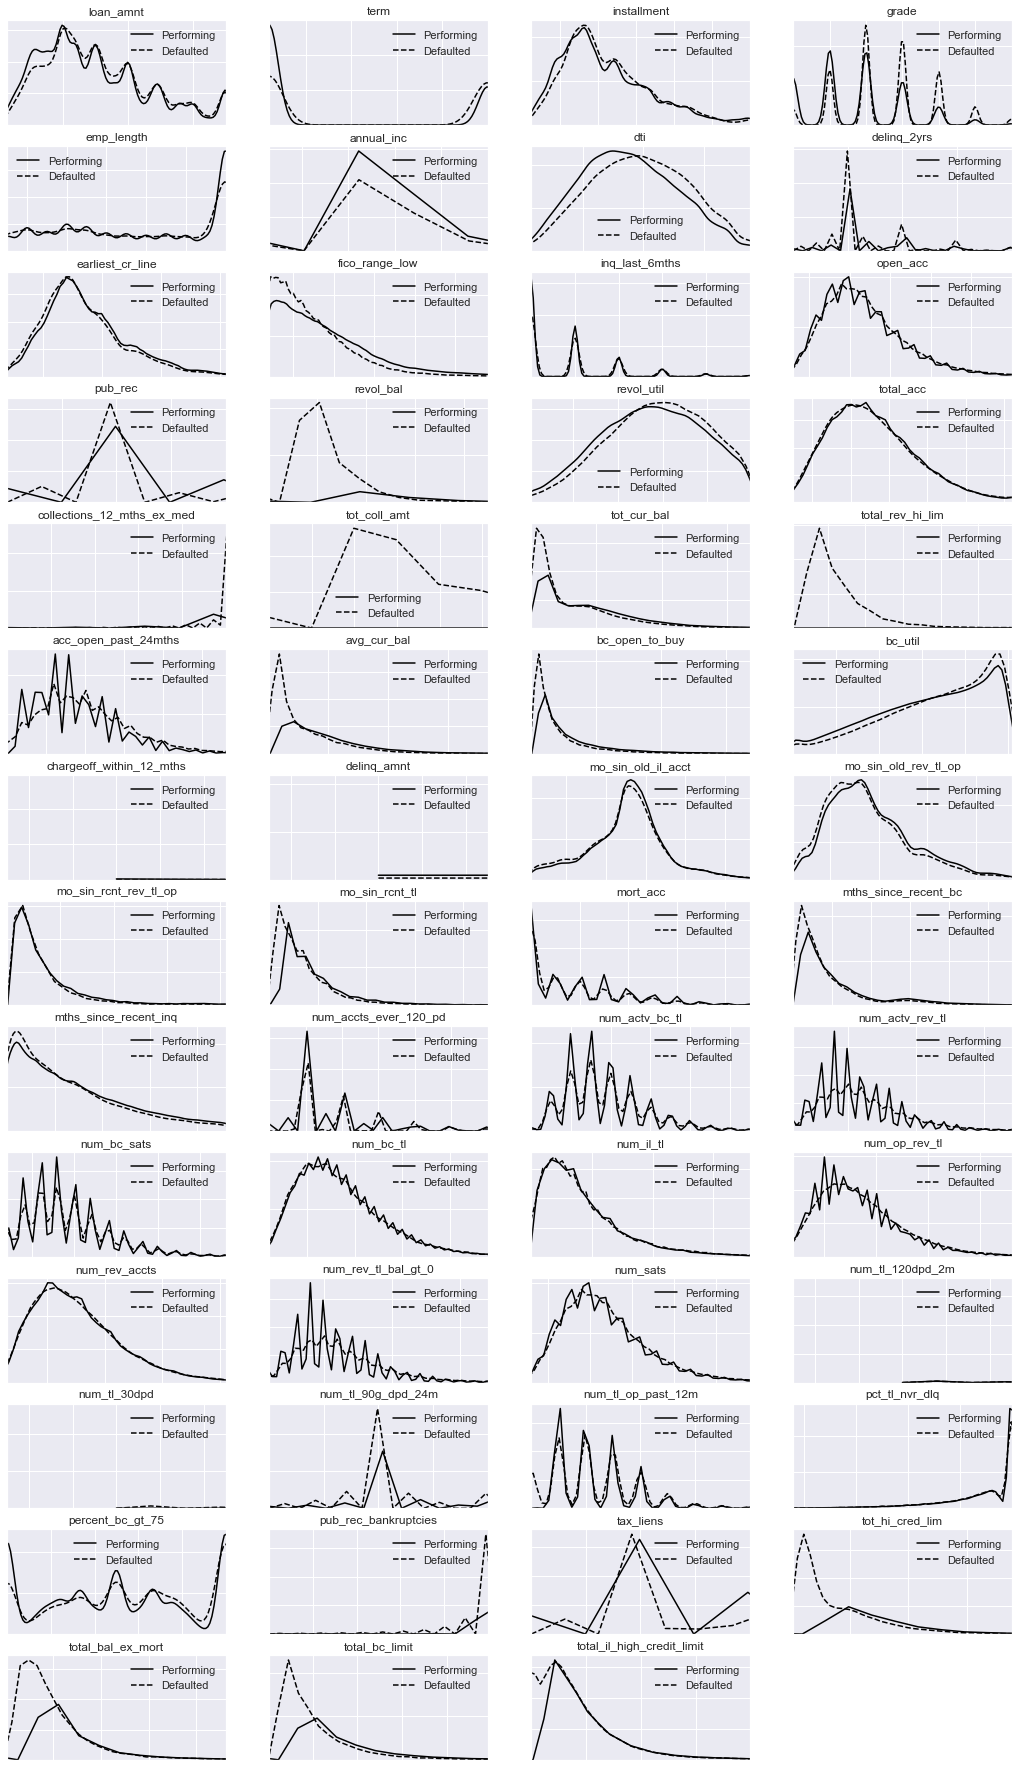

In [62]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(14,4, figsize=(18,32))

performing = dataset[dataset.target==0]
default = dataset[dataset.target==1]

num_feats = dataset.select_dtypes(['float64', 'int64']).columns[:-1] #the last feat is the target we dont need
for i, feat in enumerate(num_feats, start=1): 
    ax = plt.subplot(14,4,i)
    sns.distplot(performing[feat], hist=False, axlabel=False,
                kde_kws={'linestyle':'-', 'color':'black', 'label':'Performing'})
    sns.distplot(default[feat], hist=False, axlabel=False,
                kde_kws={'linestyle':'--', 'color':'black', 'label':'Defaulted'})
    ax.set_title(feat)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.legend(frameon=False)
    ax.set_xlim(right=max(np.nanpercentile(performing[feat],99), np.nanpercentile(default[feat],99)),
                left=min(np.nanpercentile(performing[feat],0.5), np.nanpercentile(default[feat],0.5)))
plt.subplot(14,4,56).set_visible(False)
fig.savefig('img/Densityplot.png');

Those features, which show less overlapping distribution plot for performing and defaulted loans, might be a predictors for the target variable.

## 7. Preparing dataset for modeling

In [63]:
feats = dataset.drop(columns='target').columns
print('Number of features originally:', len(feats))

Number of features originally: 59


### 7.1. Creating dummy variables from qualitative (object type) features

In [64]:
X = pd.get_dummies(dataset[feats], drop_first=True)
y = dataset.target
print(f'There are {X.shape[0]:,} observations and {X.shape[1]} features in the dataset.')

There are 232,663 observations and 72 features in the dataset.


In [65]:
print('Distribution of target variables:')
print(y.value_counts()/len(dataset))

Distribution of target variables:
0    0.823393
1    0.176607
Name: target, dtype: float64


In [66]:
# print('Features with dummies:')
# print(X.columns.to_list())

### 7.2. Train-Test Split

train : test = 80 : 20

In [67]:
#'Stratify=y' provide us the same ratio in the target variable then it was in the original dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y, test_size=0.2) 

print(f'Number of train set: {len(X_train):,}\nNumber of test set: {len(X_test):,}')

Number of train set: 186,130
Number of test set: 46,533


In [68]:
print('Test of the stratified split:')#This is a test to prove that the stratified split worked:
print('y_train:', y_train.mean())
print('y_test:', y_test.mean())

Test of the stratified split:
y_train: 0.17660774727341105
y_test: 0.17660584961210324


### 7.3. Handling Missing Values - separately for train and test

In [69]:
missing_cols = X_train.columns[X_train.isna().sum() > 0].tolist()
print('Columns with null values:\n', missing_cols)

Columns with null values:
 ['mo_sin_old_il_acct', 'mths_since_recent_inq', 'num_tl_120dpd_2m']


In [70]:
X_train[missing_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
mo_sin_old_il_acct,180474.0,128.426848,51.292454,0.0,101.0,131.0,154.0,561.0
mths_since_recent_inq,169047.0,6.910806,5.923881,0.0,2.0,5.0,10.0,25.0
num_tl_120dpd_2m,179898.0,0.000956,0.031793,0.0,0.0,0.0,0.0,2.0


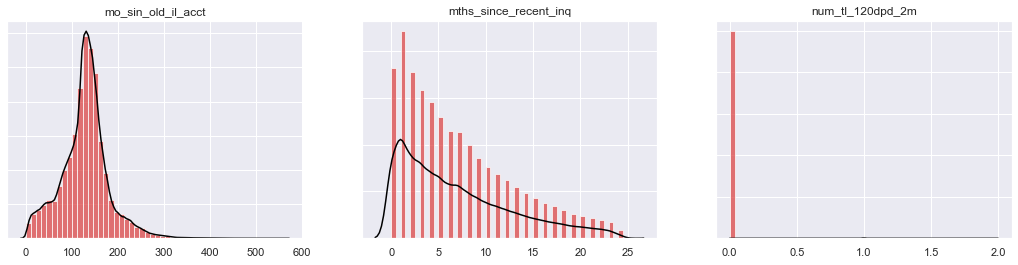

In [71]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(1,3, figsize=(18,4))

for i, feat in enumerate(missing_cols, start=1): 
    ax = plt.subplot(1,3,i)
    sns.distplot(X_train[feat].dropna(), hist=True, axlabel=False, kde_kws={'color':'black'},
                 hist_kws={'color':'#db3b3b', 'alpha':0.7})
    ax.set_title(feat)
    ax.set_yticklabels([]);

Inquiries are stored only for two years, that is why we can replace the missing values with 25.

In case of the two other featurus we will fill missing values with median.

In [72]:
#Fill nan with values:
X_train.mths_since_recent_inq.fillna(value=25)
X_test.mths_since_recent_inq.fillna(value=25)

imp = SimpleImputer(strategy='median', copy=True, fill_value=None)
imp.fit(X_train)  

X_train = imp.transform(X_train)      
X_test = imp.transform(X_test)

In [73]:
print('Check the number of nan values:')
print('X_train:', np.isnan(X_train).sum())
print('X_test:', np.isnan(X_test).sum())

Check the number of nan values:
X_train: 0
X_test: 0


### 7.4. Handling outliers

This can be done later to improve performance.

### 7.5. Scaling

The most standard scaling method

In [74]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 7.6. Save train/test sets for modeling purpuse

In [75]:
pd.DataFrame(X_train_scaled).to_csv('preprocessing/X_train.csv', header=None, index=None)
pd.DataFrame(X_test_scaled).to_csv('preprocessing/X_test.csv', header=None, index=None)
pd.DataFrame(y_train).to_csv('preprocessing/y_train.csv', header=None, index=None)
pd.DataFrame(y_test).to_csv('preprocessing/y_test.csv', header=None, index=None)